In [51]:
from PIL import Image

In [52]:
import numpy as np

In [53]:
path = "./train_test_inputs/kitti_eigen_test_files_with_gt.txt"
# path = '../eigen_test_files_with_gt_dense.txt'
# /home/duccd/Desktop/LapDepth-release/datasets/eigen_test_files_with_gt_dense.txt

In [54]:
with open(path, 'r') as f:
    filenames = f.readlines()

In [55]:
def remove_leading_slash(s):
    if s[0] == '/' or s[0] == '\\':
        return s[1:]
    return s

In [56]:
def handleNone(file_name):
    

697

In [60]:
filenames[11]

'2011_09_26/2011_09_26_drive_0002_sync/image_02/data/0000000072.png None 721.5377\n'

In [62]:
filenames[19]

'2011_09_26/2011_09_26_drive_0002_sync/image_02/data/0000000024.png 2011_09_26_drive_0002_sync/proj_depth/groundtruth/image_02/0000000024.png 721.5377\n'

In [59]:
filenames[11].split('/')

['2011_09_26',
 '2011_09_26_drive_0002_sync',
 'image_02',
 'data',
 '0000000072.png None 721.5377\n']

In [43]:
import os

In [44]:
data_path = '../KITTI_Dense_Depth'
gt_path = '../data_depth_annotated/train'

In [63]:
count_img = 0
count_gt = 0
for index, item in enumerate(filenames):
#     print(index)
    image_path = os.path.join(data_path, remove_leading_slash(item.split()[0]))
    path_split = image_path.split('/')
    gt = os.path.join(gt_path, os.path.join(path_split[3], 'proj_depth/groundtruth/image_02',path_split[-1]))
    
    if os.path.exists(gt):
        count_gt += 1
        print('right:', gt)
    else:
        print(gt)
    if os.path.exists(image_path):
        count_img += 1
    if not gt.split('/')[-1] == image_path.split('/')[-1]:
        print('false')
#         image = Image.open(image_path)
#         if image.size[0] < 1000:
#             print(image.size[0])
#             print(item)
#         height = image.height
#         width = image.width
#         top_margin = int(height - 352)
#         left_margin = int((width - 1216) / 2)
#         # depth_gt = depth_gt.crop((left_margin, top_margin, left_margin + 1216, top_margin + 352))
#         image = image.crop((left_margin, top_margin, left_margin + 1216, top_margin + 352))
#         random_angle = (random.random() - 0.5) * 2 * 1.0
#         image = rotate_image(image, random_angle)
#         image = np.asarray(image, dtype=np.float32) / 255.0
#         if image.shape[1] < 704:
#             print(image_path)
        

right: ../data_depth_annotated/train/2011_09_26_drive_0002_sync/proj_depth/groundtruth/image_02/0000000069.png
right: ../data_depth_annotated/train/2011_09_26_drive_0002_sync/proj_depth/groundtruth/image_02/0000000054.png
right: ../data_depth_annotated/train/2011_09_26_drive_0002_sync/proj_depth/groundtruth/image_02/0000000042.png
right: ../data_depth_annotated/train/2011_09_26_drive_0002_sync/proj_depth/groundtruth/image_02/0000000057.png
right: ../data_depth_annotated/train/2011_09_26_drive_0002_sync/proj_depth/groundtruth/image_02/0000000030.png
right: ../data_depth_annotated/train/2011_09_26_drive_0002_sync/proj_depth/groundtruth/image_02/0000000027.png
right: ../data_depth_annotated/train/2011_09_26_drive_0002_sync/proj_depth/groundtruth/image_02/0000000012.png
../data_depth_annotated/train/2011_09_26_drive_0002_sync/proj_depth/groundtruth/image_02/0000000075.png
right: ../data_depth_annotated/train/2011_09_26_drive_0002_sync/proj_depth/groundtruth/image_02/0000000036.png
right: .

In [46]:
print(count_img)
print(count_gt)

697
652


In [119]:
path_split

['..',
 'KITTI_Dense_Depth',
 '2011_10_03',
 '2011_10_03_drive_0034_sync',
 'image_02',
 'data',
 '0000003635.png']

In [118]:
gt

'../data_depth_annotated/train/KITTI_Dense_Depth/proj_depth/groundtruth/image_02/0000003635.png'

In [114]:
image_path = os.path.join(data_path, remove_leading_slash(filenames[100].split()[0]))

In [115]:
image = Image.open(image_path)

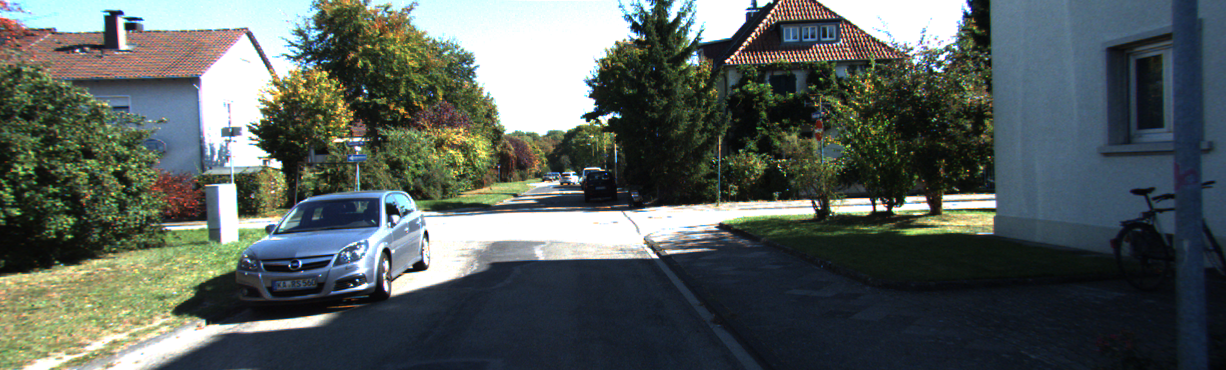

In [116]:
image

In [117]:
height = image.height
width = image.width
top_margin = int(height - 352)
left_margin = int((width - 1216) / 2)
# depth_gt = depth_gt.crop((left_margin, top_margin, left_margin + 1216, top_margin + 352))
image = image.crop((left_margin, top_margin, left_margin + 1216, top_margin + 352))

In [118]:
image.size

(1216, 352)

In [105]:
import random

In [106]:
def rotate_image(image, angle, flag=Image.BILINEAR):
    result = image.rotate(angle, resample=flag)
    return result

In [107]:
random_angle = (random.random() - 0.5) * 2 * 1.0
image = rotate_image(image, random_angle)

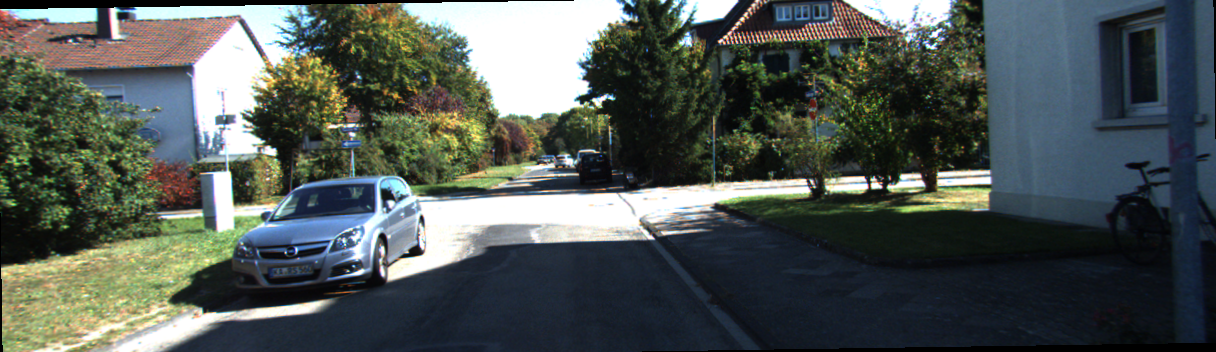

In [108]:
image

In [110]:
image = np.asarray(image, dtype=np.float32) / 255.0
# depth_gt = np.asarray(depth_gt, dtype=np.float32) 

In [111]:
image.shape

(352, 1216, 3)

In [112]:
image.shape[1]

1216

In [113]:
image.shape[0]


352

In [10]:
gt

'../data_depth_annotated/train/2011_10_03_drive_0047_sync/proj_depth/groundtruth/image_02/0000000768.png'

In [17]:
import PIL.Image as pil

In [18]:
image = Image.open(gt)

In [19]:
input_image = pil.open(gt)

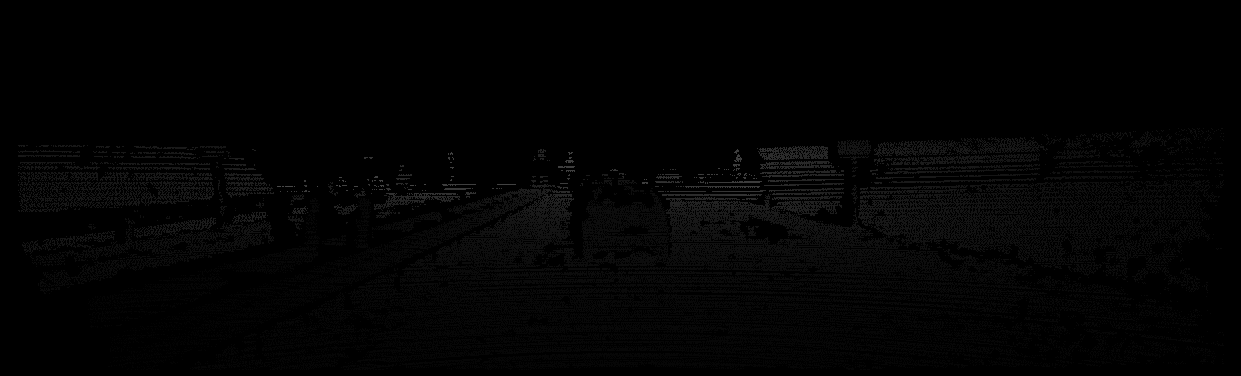

In [28]:
input_image

In [21]:
import numpy as np

In [22]:
import PIL.Image as Image

depth_map = np.asarray(Image.open(gt)) / 256.0
depth_gt = np.expand_dims(depth_map, axis=2)


In [24]:
depth_gt.shape

(376, 1241, 1)

In [26]:
depth_map.shape

(376, 1241)